In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support,f1_score,recall_score,precision_score

%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

In this assignment, you will measure the performance of the model you created with the Titanic data in the previous lesson.
- Evaluate the performance of your model with the metrics you have learned in this course.
- Plot the ROC and the precision / recall curves.

In [2]:
train_df = pd.read_csv("C:/Users/Ahmet/Desktop/data/train.csv")
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


In [3]:
def detect_outliers(df,features):
    outlier_indices = []
    
    for c in features:
        # 1st quartile
        Q1 = np.percentile(df[c],25)
        # 3rd quartile
        Q3 = np.percentile(df[c],75)
        # IQR
        IQR = Q3 - Q1
        # Outlier step
        outlier_step = IQR * 1.5
        # Detect outlier and their indeces
        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        # Store indeces
        outlier_indices.extend(outlier_list_col)
    
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i, v in outlier_indices.items() if v > 2)
    
    return multiple_outliers

In [4]:
train_df.loc[detect_outliers(train_df,["Age","SibSp","Parch","Fare"])]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.000,3,2,19950,263.000,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.000,3,2,19950,263.000,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,nan,8,2,CA. 2343,69.550,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,nan,8,2,CA. 2343,69.550,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,nan,8,2,CA. 2343,69.550,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,nan,8,2,CA. 2343,69.550,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.000,3,2,19950,263.000,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,nan,8,2,CA. 2343,69.550,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,nan,8,2,CA. 2343,69.550,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,nan,8,2,CA. 2343,69.550,NaN,S


In [5]:
# drop outliers
train_df = train_df.drop(detect_outliers(train_df,["Age","SibSp","Parch","Fare"]),axis = 0).reset_index(drop = True)

In [6]:
train_df.columns[train_df.isnull().any()]

Index(['Age', 'Cabin', 'Embarked'], dtype='object')

In [7]:
train_df["Embarked"] = train_df["Embarked"].fillna("C")
train_df[train_df["Embarked"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [8]:
index_miss_age = list(train_df["Age"][train_df["Age"].isnull()].index)
for i in index_miss_age:
    age_pred = train_df["Age"][((train_df["SibSp"] == train_df.iloc[i]["SibSp"]) &(train_df["Parch"] == train_df.iloc[i]["Parch"])& (train_df["Pclass"] == train_df.iloc[i]["Pclass"]))].median()
    age_med = train_df["Age"].median()
    if not np.isnan(age_pred):
        train_df["Age"].iloc[i] = age_pred
    else:
        train_df["Age"].iloc[i] = age_med

In [9]:
train_df[train_df["Age"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [10]:
name = train_df["Name"]
train_df["Title"] = [i.split(".")[0].split(",")[-1].strip() for i in name]

In [11]:
# convert to categorical
train_df["Title"] = train_df["Title"].replace(["Lady","the Countess","Capt","Col","Don","Dr","Major","Rev","Sir","Jonkheer","Dona"],"other")
train_df["Title"] = [0 if i == "Master" else 1 if i == "Miss" or i == "Ms" or i == "Mlle" or i == "Mrs" else 2 if i == "Mr" else 3 for i in train_df["Title"]]
train_df["Title"].head(20)

0     2
1     1
2     1
3     1
4     2
5     2
6     2
7     0
8     1
9     1
10    1
11    1
12    2
13    2
14    1
15    1
16    0
17    2
18    1
19    1
Name: Title, dtype: int64

In [12]:
train_df = pd.get_dummies(train_df,columns=["Title"])

In [13]:
train_df.drop(labels = ["Name"], axis = 1, inplace = True)
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title_0,Title_1,Title_2,Title_3
0,1,0,3,male,22.000,1,0,A/5 21171,7.250,NaN,S,0,0,1,0
1,2,1,1,female,38.000,1,0,PC 17599,71.283,C85,C,0,1,0,0
2,3,1,3,female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S,0,1,0,0
3,4,1,1,female,35.000,1,0,113803,53.100,C123,S,0,1,0,0
4,5,0,3,male,35.000,0,0,373450,8.050,NaN,S,0,0,1,0


In [14]:
train_df["FamSize"] = train_df["SibSp"] + train_df["Parch"] + 1
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title_0,Title_1,Title_2,Title_3,FamSize
0,1,0,3,male,22.000,1,0,A/5 21171,7.250,NaN,S,0,0,1,0,2
1,2,1,1,female,38.000,1,0,PC 17599,71.283,C85,C,0,1,0,0,2
2,3,1,3,female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S,0,1,0,0,1
3,4,1,1,female,35.000,1,0,113803,53.100,C123,S,0,1,0,0,2
4,5,0,3,male,35.000,0,0,373450,8.050,NaN,S,0,0,1,0,1


In [15]:
train_df["family_size"] = [1 if i < 5 else 0 for i in train_df["FamSize"]]
train_df.head(10)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title_0,Title_1,Title_2,Title_3,FamSize,family_size
0,1,0,3,male,22.000,1,0,A/5 21171,7.250,NaN,S,0,0,1,0,2,1
1,2,1,1,female,38.000,1,0,PC 17599,71.283,C85,C,0,1,0,0,2,1
2,3,1,3,female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S,0,1,0,0,1,1
3,4,1,1,female,35.000,1,0,113803,53.100,C123,S,0,1,0,0,2,1
4,5,0,3,male,35.000,0,0,373450,8.050,NaN,S,0,0,1,0,1,1
5,6,0,3,male,26.000,0,0,330877,8.458,NaN,Q,0,0,1,0,1,1
6,7,0,1,male,54.000,0,0,17463,51.862,E46,S,0,0,1,0,1,1
7,8,0,3,male,2.000,3,1,349909,21.075,NaN,S,1,0,0,0,5,0
8,9,1,3,female,27.000,0,2,347742,11.133,NaN,S,0,1,0,0,3,1
9,10,1,2,female,14.000,1,0,237736,30.071,NaN,C,0,1,0,0,2,1


In [16]:
train_df["Pclass"] = train_df["Pclass"].astype("category")
train_df["Sex"] = train_df["Sex"].astype("category")
train_df = pd.get_dummies(train_df, columns= ["family_size","Embarked","Pclass","Sex"])
train_df.head()

,PassengerId,Survived,Age,SibSp,Parch,Ticket,Fare,Cabin,Title_0,Title_1,...,family_size_0,family_size_1,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
0,1,0,22.000,1,0,A/5 21171,7.250,NaN,0,0,...,0,1,0,0,1,0,0,1,0,1
1,2,1,38.000,1,0,PC 17599,71.283,C85,0,1,...,0,1,1,0,0,1,0,0,1,0
2,3,1,26.000,0,0,STON/O2. 3101282,7.925,NaN,0,1,...,0,1,0,0,1,0,0,1,1,0
3,4,1,35.000,1,0,113803,53.100,C123,0,1,...,0,1,0,0,1,1,0,0,1,0
4,5,0,35.000,0,0,373450,8.050,NaN,0,0,...,0,1,0,0,1,0,0,1,0,1


In [17]:
train_df.drop(labels = ["PassengerId", "Cabin", "Ticket"], axis = 1, inplace = True)
train_df.columns

Index(['Survived', 'Age', 'SibSp', 'Parch', 'Fare', 'Title_0', 'Title_1',
       'Title_2', 'Title_3', 'FamSize', 'family_size_0', 'family_size_1',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Sex_female', 'Sex_male'],
      dtype='object')

In [18]:
X = train_df.drop(["Survived"],axis=1)
y = train_df["Survived"]

In [19]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.20, random_state=111)

In [20]:
log_reg = LogisticRegression(solver='lbfgs', multi_class="ovr")
log_reg.fit(X_train, y_train)
train_accuracy = log_reg.score(X_train, y_train)
test_accuracy = log_reg.score(X_test, y_test)

print('One-vs.-Rest', '-'*30, 
      'Accuracy on Train Data : {:.2f}'.format(train_accuracy), 
      'Accuracy on Test Data  : {:.2f}'.format(test_accuracy), sep='\n')

One-vs.-Rest
------------------------------
Accuracy on Train Data : 0.83
Accuracy on Test Data  : 0.82


In [21]:
from sklearn.metrics import confusion_matrix , accuracy_score

y_pred = log_reg.predict(X_test)

# Print the prediction accuracy
print(accuracy_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)

0.8248587570621468


array([[91, 14],
       [17, 55]], dtype=int64)

- Our two models work with accuracy score of 83%. That looks pretty satisfying and when we check our precision score that looks enough. Long story short, Our model is totally enough.

In [23]:
print(classification_report(y_test, y_pred))

print("f1_score() value        : {:.2f}".format(f1_score(y_test, y_pred)))
print("recall_score() value    : {:.2f}".format(recall_score(y_test, y_pred)))
print("precision_score() value : {:.2f}".format(precision_score(y_test, y_pred)))
print('\n')

metrics = precision_recall_fscore_support(y_test, y_pred)
print("Precision  :" , metrics[0]) 
print("Recall     :" , metrics[1]) 
print("F1 Score   :" , metrics[2]) 

              precision    recall  f1-score   support

           0       0.84      0.87      0.85       105
           1       0.80      0.76      0.78        72

    accuracy                           0.82       177
   macro avg       0.82      0.82      0.82       177
weighted avg       0.82      0.82      0.82       177

f1_score() value        : 0.78
recall_score() value    : 0.76
precision_score() value : 0.80


Precision  : [0.84259259 0.79710145]
Recall     : [0.86666667 0.76388889]
F1 Score   : [0.85446009 0.78014184]


- Our accuracy value seems to be sufficient with 82%. Precision, recall and f1 scores seem good and sufficient. They took the values ​​of 80%, 76% and 78%, respectively. In this case, we can say that our model is sufficient and in good working condition.

In [29]:
test_prediction_proba = log_reg.predict_proba(X_test)[:,1]

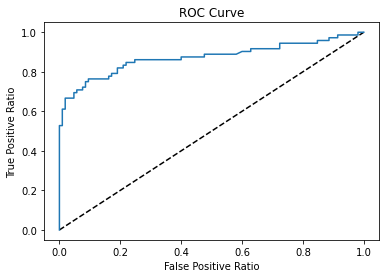

AUC value :  0.8723544973544973


In [37]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds  = roc_curve(y_test, test_prediction_proba)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)

plt.xlabel('False Positive Ratio')
plt.ylabel('True Positive Ratio')
plt.title('ROC Curve')

plt.show()
print('AUC value : ', roc_auc_score(y_test, test_prediction_proba))

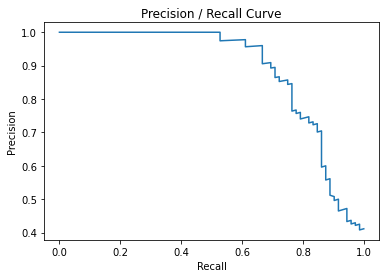

In [35]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, test_prediction_proba)

plt.plot(recall, precision)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision / Recall Curve')

plt.show()